In [11]:
import pandas as pd
from methcomp import *

# HOLA JULIANA QUE TAL?
# ESTO ES PARA CARGAR LOS CSV

# Function to extract glucose concentration and ascorbic acid presence from 'Sample ID'
def extract_info_from_id(sample_id):
    glucose = None
    hematocrit = 'low' if '*' not in sample_id else 'high'
    ascorbic_acid = True if 'Lemon' in sample_id else False
    for part in sample_id.split():
        if part.isdigit():
            glucose = int(part)
            break
    return glucose, hematocrit, ascorbic_acid

# Function to convert mmol/L to mg/dL
def mmol_to_mgdl(mmol_value):
    return int(mmol_value * 18.0182)  # Conversion factor for glucose

# Function to clean and convert values with commas as decimal separators
def clean_and_convert(value):
    if isinstance(value, str):
        value = value.replace(',', '.')  # Replace commas with dots for decimal points
        try:
            return float(value)  # Convert to float if possible
        except ValueError:
            return value  # Return original value if conversion fails
    return value  # Return the value directly if it's not a string


# Function to apply the extracted information and conversion to the DataFrame
def map_dataframe(df):
    # Extract and apply the information from each 'Sample ID'
    df['Glucose Concentration (mg/dL)'], df['Hematocrit Level'], df['Ascorbic Acid Present'] = zip(*df['Sample ID'].apply(extract_info_from_id))
    
    # Convert mmol/L to mg/dL for columns with "Replicate" and values less than 20
    replicate_cols = [col for col in df.columns if "Replicate" in col]
    for col in replicate_cols:
        df[col] = df[col].apply(clean_and_convert).apply(lambda x: mmol_to_mgdl(x) if isinstance(x, (int, float)) and x < 20 else x)

    return df

# Load the DataFrame without headers and assign 'Sample ID' and 'Replicate N' names
def load_and_map_csv(filepath):
    df = pd.read_csv(filepath, header=None)
    df.columns = ['Sample ID'] + ['Replicate ' + str(i) for i in range(1, len(df.columns))]
    return map_dataframe(df)

# Load and map each DataFrame
ebwell_df = load_and_map_csv('ebwell.csv')
truemetrix_df = load_and_map_csv('TrueMetrix.csv')
accucheck_df = load_and_map_csv('Accucheck performa.csv')


In [12]:
# ESTO ES PARA TROUBLESHOOTING NO MIRES AQUI

for index, row in ebwell_df.iterrows():
    print(f"Index: {index}, Sample ID: {row['Sample ID']}, Hematocrit Level: {row['Hematocrit Level']}, "
          f"Ascorbic Acid Present: {row['Ascorbic Acid Present']}, Glucose Concentration (mg/dL): {row['Glucose Concentration (mg/dL)']}")

Index: 0, Sample ID: A - 70, Hematocrit Level: low, Ascorbic Acid Present: False, Glucose Concentration (mg/dL): 70
Index: 1, Sample ID: B - 90, Hematocrit Level: low, Ascorbic Acid Present: False, Glucose Concentration (mg/dL): 90
Index: 2, Sample ID: H - 100, Hematocrit Level: low, Ascorbic Acid Present: False, Glucose Concentration (mg/dL): 100
Index: 3, Sample ID: C - 110, Hematocrit Level: low, Ascorbic Acid Present: False, Glucose Concentration (mg/dL): 110
Index: 4, Sample ID: D - 130, Hematocrit Level: low, Ascorbic Acid Present: False, Glucose Concentration (mg/dL): 130
Index: 5, Sample ID: F - 1000, Hematocrit Level: low, Ascorbic Acid Present: False, Glucose Concentration (mg/dL): 1000
Index: 6, Sample ID: G - 90 + Lemon, Hematocrit Level: low, Ascorbic Acid Present: True, Glucose Concentration (mg/dL): 90
Index: 7, Sample ID: A* - 70, Hematocrit Level: high, Ascorbic Acid Present: False, Glucose Concentration (mg/dL): 70
Index: 8, Sample ID: B* - 90, Hematocrit Level: high,

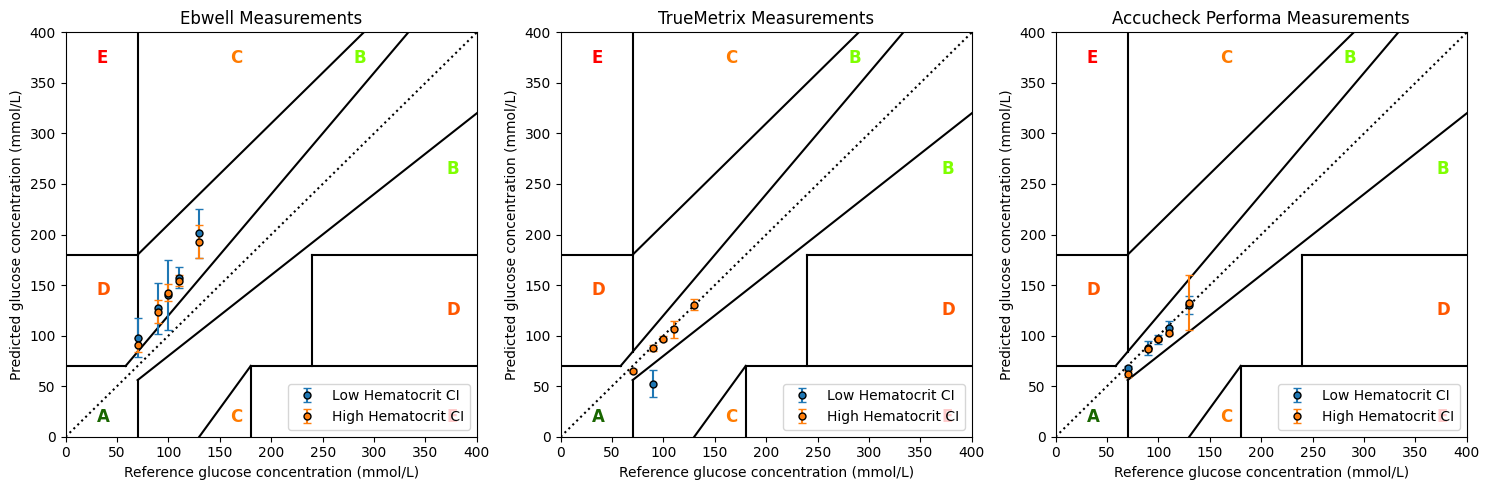

In [22]:
# ESTO ES UN BIG MESS PARA EL PLOT DE CLARKE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def clean_replicates(df):
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    for col in df_copy.columns[1:]:  # Assuming the first column is 'Sample ID'
        df_copy[col] = pd.to_numeric(df_copy[col].astype(str).str.replace(',', '.'), errors='coerce')
    return df_copy


def calc_mean_conf(df, hematocrit, dispplay=False):
    # Filter dataframe for the given hematocrit level, excluding glucose 1000 and non-numeric values
    df_filtered = df[(df['Hematocrit Level'] == hematocrit) & (df['Glucose Concentration (mg/dL)'] != 1000)]
    df_filtered = clean_replicates(df_filtered)  # Ensure only numeric data is included

    # Identify the columns with "Replicate" in their names
    replicate_cols = [col for col in df_filtered.columns if 'Replicate' in col]

    # Create new columns for Mean, Std, and Counts
    df_filtered['Mean'] = df_filtered[replicate_cols].mean(axis=1)
    df_filtered['Std'] = df_filtered[replicate_cols].std(axis=1)
    df_filtered['Counts'] = df_filtered[replicate_cols].count(axis=1)



    # Remove rows with NaN values in Mean, Std, or Counts
    df_filtered = df_filtered.dropna(subset=['Mean', 'Std', 'Counts'])

    # Calculate degrees of freedom
    degrees_of_freedom = df_filtered['Counts'] - 1

    # Ensure we have more than one observation to calculate the t-distribution critical value
    t_values = t.ppf((1 + 0.95) / 2., degrees_of_freedom)
    ci = df_filtered['Std'] * t_values / np.sqrt(df_filtered['Counts'])

    result_df = df_filtered[['Glucose Concentration (mg/dL)', 'Mean']].copy()
    result_df['Confidence Interval'] = ci

    if dispplay:
        display(result_df)

    return result_df


# Function to plot data with confidence intervals as shaded areas
def plot_with_confidence(df, title):
    plt.figure(figsize=(10, 5))
    
    # Plot for each hematocrit level
    for hematocrit in ['low', 'high']:
        result_df = calc_mean_conf(df, hematocrit)
        data = result_df['Mean']
        confs = result_df['Confidence Interval']

        plt.plot(result_df['Glucose Concentration (mg/dL)'], data, label=f'{hematocrit.capitalize()} Hematocrit', marker='o')

        # Create a shaded area for the confidence interval
        plt.fill_between(result_df['Glucose Concentration (mg/dL)'], data - confs, data + confs, alpha=0.2)

    plt.title(title)
    plt.xlabel('Glucose Concentration (mg/dL)')
    plt.ylabel('Average Measurement')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create subplots for each hematocrit level
def create_subplots(df, title, ax):
    for hematocrit in ['low', 'high']:
        result_df = calc_mean_conf(df, hematocrit)
        data = result_df['Mean']
        if "True" in title:
            display(data)
        confs = result_df['Confidence Interval']

        ax.plot(result_df['Glucose Concentration (mg/dL)'], data, label=f'{hematocrit.capitalize()} Hematocrit', marker='o')

        # Create a shaded area for the confidence interval
        ax.fill_between(result_df['Glucose Concentration (mg/dL)'], data - confs, data + confs, alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel('Glucose Concentration (mg/dL)')
    ax.set_ylabel('Average Measurement')
    ax.legend()
    ax.grid(True)

# Function to create Clarke Error Grid subplots with error bars
def create_clarke_subplots(df, title, ax):
    # Generate results for low and high hematocrit levels
    low_hematocrit_results = calc_mean_conf(df, 'low')
    high_hematocrit_results = calc_mean_conf(df, 'high')

    # Plot Clarke Error Grid for low hematocrit level
    clarke(
        reference=low_hematocrit_results['Glucose Concentration (mg/dL)'].values,
        test=low_hematocrit_results['Mean'].values,
        units='mg/dl',
        ax=ax
    )

    # Overlay error bars for low hematocrit with custom colors
    ax.errorbar(
        low_hematocrit_results['Glucose Concentration (mg/dL)'],
        low_hematocrit_results['Mean'],
        yerr=low_hematocrit_results['Confidence Interval'],
        fmt='o', ecolor='#1f77b4', capsize=3, elinewidth=1.5, markeredgewidth=1,
        label='Low Hematocrit CI', color='#1f77b4', markersize=5, markeredgecolor='black'
    )

    # Overlay error bars for high hematocrit with custom colors
    ax.errorbar(
        high_hematocrit_results['Glucose Concentration (mg/dL)'],
        high_hematocrit_results['Mean'],
        yerr=high_hematocrit_results['Confidence Interval'],
        fmt='o', ecolor='#ff7f0e', capsize=3, elinewidth=1.5, markeredgewidth=1,
        label='High Hematocrit CI', color='#ff7f0e', markersize=5, markeredgecolor='black'
    )

    # Set the title and add the legend
    ax.set_title(title)
    ax.legend()


# Load and map each DataFrame
ebwell_df = load_and_map_csv('ebwell.csv')
truemetrix_df = load_and_map_csv('TrueMetrix.csv')
accucheck_df = load_and_map_csv('Accucheck performa.csv')

# Create a single figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Increased size for clarity

# Plot each dataset on a separate subplot with Clarke Error Grid and overlay
create_clarke_subplots(ebwell_df, 'Ebwell Measurements', axes[0])
create_clarke_subplots(truemetrix_df, 'TrueMetrix Measurements', axes[1])
create_clarke_subplots(accucheck_df, 'Accucheck Performa Measurements', axes[2])

plt.tight_layout()
plt.show()

c:\Users\franx\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\franx\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


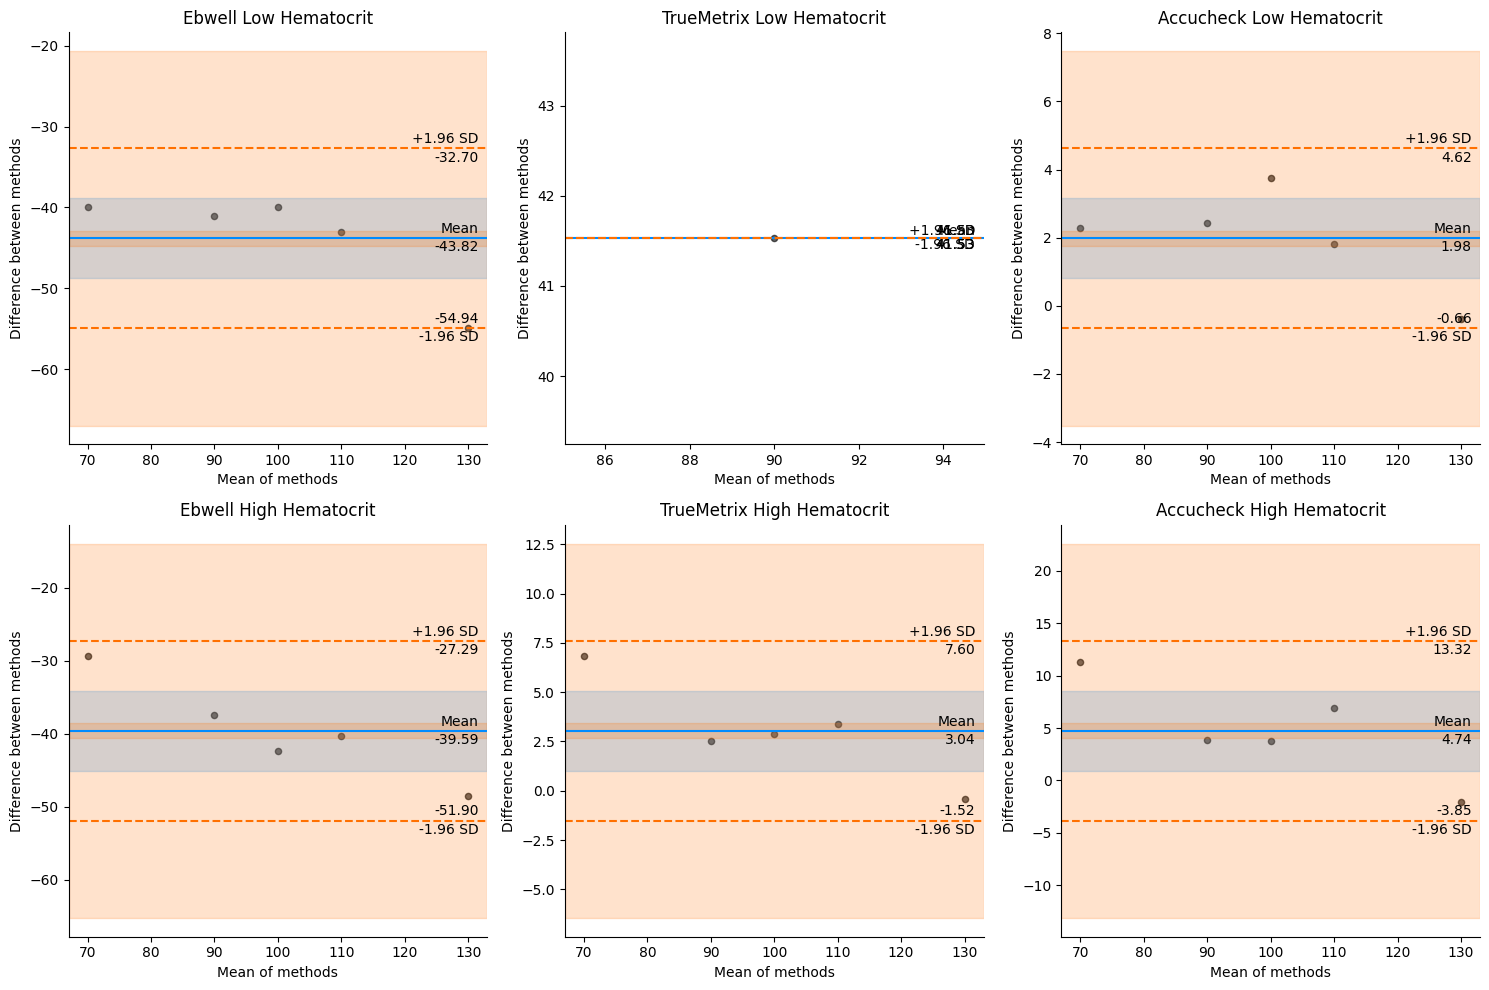

In [26]:
#BUNDERMAN & ANTMAN PLOT

import matplotlib.pyplot as plt
from methcomp import blandaltman

# Assuming that you have loaded your dataframes ebwell_df, truemetrix_df, accucheck_df
# and you have defined the function calc_mean_conf

# First, calculate the mean and differences for high and low hematocrit for each device
ebwell_low = calc_mean_conf(ebwell_df, 'low')
ebwell_high = calc_mean_conf(ebwell_df, 'high')
truemetrix_low = calc_mean_conf(truemetrix_df, 'low')
truemetrix_high = calc_mean_conf(truemetrix_df, 'high')
accucheck_low = calc_mean_conf(accucheck_df, 'low')
accucheck_high = calc_mean_conf(accucheck_df, 'high')

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot Bland-Altman for each condition
# For low hematocrit
blandaltman(ebwell_low['Glucose Concentration (mg/dL)'], ebwell_low['Mean'], ax=axes[0, 0],diff="percentage")
blandaltman(truemetrix_low['Glucose Concentration (mg/dL)'], truemetrix_low['Mean'], ax=axes[0, 1],diff="percentage")
blandaltman(accucheck_low['Glucose Concentration (mg/dL)'], accucheck_low['Mean'], ax=axes[0, 2],diff="percentage")

# For high hematocrit
blandaltman(ebwell_high['Glucose Concentration (mg/dL)'], ebwell_high['Mean'], ax=axes[1, 0],diff="percentage")
blandaltman(truemetrix_high['Glucose Concentration (mg/dL)'], truemetrix_high['Mean'], ax=axes[1, 1],diff="percentage")
blandaltman(accucheck_high['Glucose Concentration (mg/dL)'], accucheck_high['Mean'], ax=axes[1, 2],diff="percentage")

# Set titles for each subplot
axes[0, 0].set_title('Ebwell Low Hematocrit')
axes[0, 1].set_title('TrueMetrix Low Hematocrit')
axes[0, 2].set_title('Accucheck Low Hematocrit')
axes[1, 0].set_title('Ebwell High Hematocrit')
axes[1, 1].set_title('TrueMetrix High Hematocrit')
axes[1, 2].set_title('Accucheck High Hematocrit')

# Optionally, adjust layout, add grid, etc.
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd

# Function definitions (assuming they are the same as provided before)

# Load and map each DataFrame
ebwell_df = load_and_map_csv('ebwell.csv')
truemetrix_df = load_and_map_csv('TrueMetrix.csv')
accucheck_df = load_and_map_csv('Accucheck performa.csv')

# Define a function to filter and display the DataFrame rows based on conditions
def display_filtered_rows(df, name):
    # Filter for rows with citric acid present
    citric_acid_present = df[df['Ascorbic Acid Present'] == True]
    return citric_acid_present
    # print(f"{name} DataFrame with Citric Acid Present:")
    # print(citric_acid_present, '\n')

    # # Filter for rows with glucose concentration of 1000 mg/dL
    # glucose_1000 = df[df['Glucose Concentration (mg/dL)'] == 1000]
    # print(f"{name} DataFrame with Glucose Concentration of 1000 mg/dL:")
    # print(glucose_1000, '\n')

# Display filtered rows for each DataFrame
df3 = display_filtered_rows(truemetrix_df, 'TrueMetrix')

df3[df3["Sample ID"] == "G - 90 + Lemon"]



,Sample ID,Replicate 1,Replicate 2,Replicate 3,Replicate 4,Replicate 5,Replicate 6,Replicate 7,Replicate 8,Replicate 9,...,Replicate 35,Replicate 36,Replicate 37,Replicate 38,Replicate 39,Replicate 40,Replicate 41,Glucose Concentration (mg/dL),Hematocrit Level,Ascorbic Acid Present
6,G - 90 + Lemon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,37,68,NaN,75,41.0,39.0,90,low,True


AttributeError: 'NoneType' object has no attribute 'mean'

C:\Users\franx\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


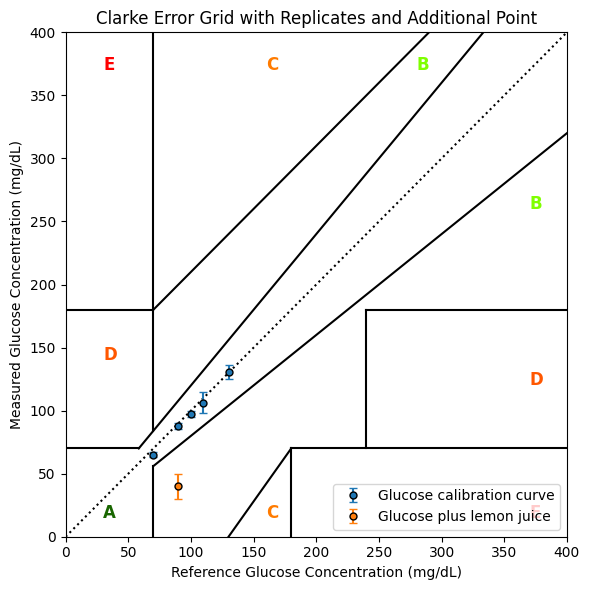

In [55]:
# Reuse your existing functions here

def plot_clarke_with_error_bars_and_additional_point(df, ax, sample_id_for_additional_point):
    # Calculate mean and confidence intervals
    results_with_ci = calc_mean_conf(df, 'high')  # or 'low', depending on what you're plotting

    
    # Plot Clarke Error Grid
    clarke(
        reference=results_with_ci['Glucose Concentration (mg/dL)'].values,
        test=results_with_ci['Mean'].values,
        units='mg/dl',
        ax=ax
    )
    
    # Overlay the replicates with error bars
    ax.errorbar(
        results_with_ci['Glucose Concentration (mg/dL)'],
        results_with_ci['Mean'],
        yerr=results_with_ci['Confidence Interval'],
        fmt='o',
        color="#1f77b4",
        ecolor="#1f77b4",
        elinewidth=1.5,
        markeredgewidth=1,
        markersize=5,
        markeredgecolor='black',
        capsize=3,
        label='Glucose calibration curve'
    )
    
    # Plot the additional point with its error bars
    specific_row = df[df['Sample ID'] == sample_id_for_additional_point]

    specific_row["Std"] = 10
    ax.errorbar(
        specific_row['Glucose Concentration (mg/dL)'],
        specific_row['Mean'],
        yerr=specific_row['Std'],
        fmt='o',
        color="#ff7f0e",
        ecolor="#ff7f0e",
        elinewidth=1.5,
        markeredgewidth=1,
        markersize=5,
        markeredgecolor='black',
        capsize=3,
        label='Glucose plus lemon juice'
    )
    
    # Adding labels and title
    ax.set_xlabel('Reference Glucose Concentration (mg/dL)')
    ax.set_ylabel('Measured Glucose Concentration (mg/dL)')
    ax.set_title('Clarke Error Grid with Replicates and Additional Point')
    ax.legend()

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming you have a DataFrame loaded as `truemetrix_df`
plot_clarke_with_error_bars_and_additional_point(truemetrix_df, ax, 'G - 90 + Lemon')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

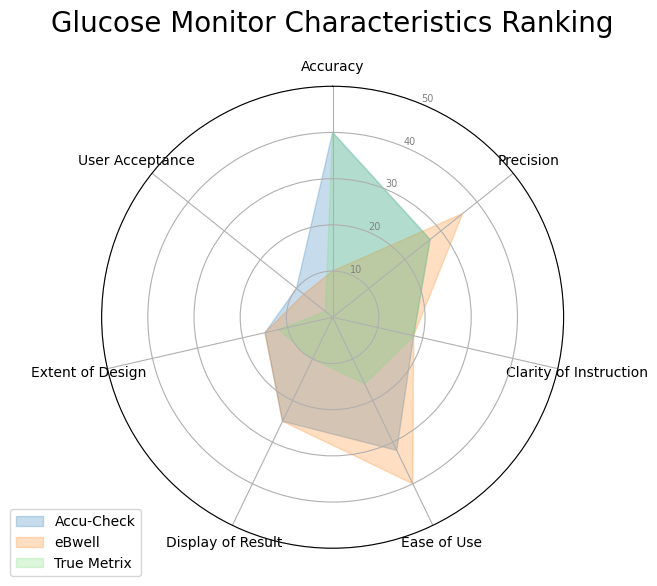

: 

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# Define data
labels=np.array(['Accuracy', 'Precision', 'Clarity of Instruction', 'Ease of Use', 'Display of Result', 'Extent of Design', 'User Acceptance'])
stats=np.array([40, 27, 18, 32, 25, 15, 10])  # Replace with actual Accu-Check scores
stats2=np.array([10, 36, 18, 40, 25, 15, 8])  # Replace with actual eBwell scores
stats3=np.array([40, 27, 18, 16, 10, 12, 2])  # Replace with actual True Metrix scores

# Create radar chart
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
stats=np.concatenate((stats,[stats[0]]))
stats2=np.concatenate((stats2,[stats2[0]]))
stats3=np.concatenate((stats3,[stats3[0]]))
angles+=angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='#1f77b4', alpha=0.25)
ax.fill(angles, stats2, color='#ff7f0e', alpha=0.25)
ax.fill(angles, stats3, color='#77dd77', alpha=0.25)  # Pastel green
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], labels)

# Draw yticks
ax.set_rscale('linear')
plt.yticks(color='grey', size=7)
plt.ylim(0,50)

# Add legend and title
plt.title('Glucose Monitor Characteristics Ranking', size=20, color='black', y=1.1)
ax.legend(labels=['Accu-Check', 'eBwell', 'True Metrix'], loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()
